Loading master dataset

In [28]:
import pandas as pd
import numpy as np

df = pd.read_csv("master_dataset.csv")

df.columns


Index(['timestamp_trial', 'participant', 'condition', 'order', 'difficulty',
       'satisfaction', 'nervousness', 'time_raw', 'time_minutes',
       'timestamp_q', 'known_audience', 'age', 'gender', 'nationality',
       'sudoku_frequency', 'comfort_watched', 'performed_audience',
       'performance_frequency'],
      dtype='object')

##### Sanity checks + raw plots

Plotting time by order (to justify the use of ANOVA bc second trials are faster)

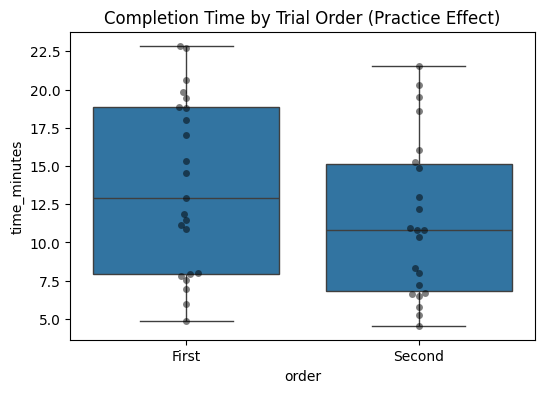

In [29]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(6,4))
sns.boxplot(data=df, x='order', y='time_minutes')
sns.swarmplot(data=df, x='order', y='time_minutes', color='black', alpha=0.5)
plt.title("Completion Time by Trial Order (Practice Effect)")
plt.show()

Plotting time by condition (RAW audience effect) to show raw differences and ignoring practice and counterbalancing, so ANOVA is necessary

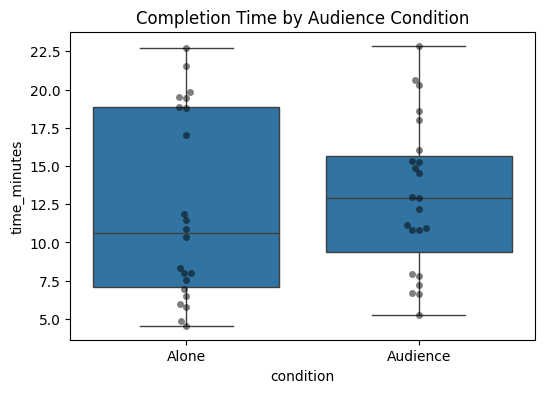

In [30]:
plt.figure(figsize=(6,4))
sns.boxplot(data=df, x='condition', y='time_minutes')
sns.swarmplot(data=df, x='condition', y='time_minutes', color='black', alpha=0.5)
plt.title("Completion Time by Audience Condition")
plt.show()

##### 2x2 mixed ANOVA

Derive which condition was first per participant

In [31]:
import numpy as np
import pandas as pd

# Assuming df is your master dataset
# Keep only the 'First' trials
first_trials = (
    df[df['order'] == 'First']
    .loc[:, ['participant', 'condition']]
    .drop_duplicates()
)

first_trials.head()

first_trials['order_group'] = np.where(
    first_trials['condition'] == 'Audience',
    'AudienceFirst',
    'AloneFirst'
)

first_trials.head()

df = df.merge(
    first_trials[['participant', 'order_group']],
    on='participant',
    how='left'
)

df['order_group'] = df['order_group'].astype('category')

df[['participant', 'condition', 'order', 'order_group']].head()




,participant,condition,order,order_group
0,2,Alone,First,AloneFirst
1,2,Audience,Second,AloneFirst
2,1,Audience,First,AudienceFirst
3,1,Alone,Second,AudienceFirst
4,3,Audience,First,AudienceFirst


In [36]:
df.groupby('order_group')['participant'].nunique()


C:\Users\maria\AppData\Local\Temp\ipykernel_17924\1419306305.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby('order_group')['participant'].nunique()


order_group
AloneFirst       14
AudienceFirst     9
Name: participant, dtype: int64

In [47]:
import pingouin as pg

df_anova = df.dropna(subset=['time_minutes', 'condition', 'order_group', 'participant'])

df_anova.to_csv("anova_dataset.csv", index=False)

mixed = pg.mixed_anova(
    dv='time_minutes',
    within='condition',
    between='order_group',
    subject='participant',
    data=df_anova
)

mixed


,Source,SS,DF1,DF2,MS,F,p-unc,np2,eps
0,order_group,0.004939,1,20,0.004939,0.000096,0.992263,0.000005,NaN
1,condition,6.200006,1,20,6.200006,0.506347,0.484942,0.024692,1.0
2,Interaction,66.702742,1,20,66.702742,5.447533,0.030141,0.214069,NaN


##### Paired plots

C:\Users\maria\AppData\Local\Temp\ipykernel_17924\3922484214.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


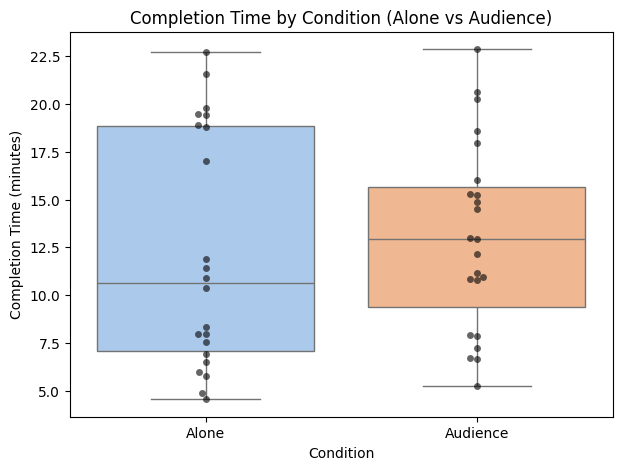

In [39]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(7,5))
sns.boxplot(
    data=df,
    x='condition',
    y='time_minutes',
    palette="pastel"
)
sns.swarmplot(
    data=df,
    x='condition',
    y='time_minutes',
    color='black',
    alpha=0.6
)

plt.title("Completion Time by Condition (Alone vs Audience)")
plt.xlabel("Condition")
plt.ylabel("Completion Time (minutes)")
plt.show()



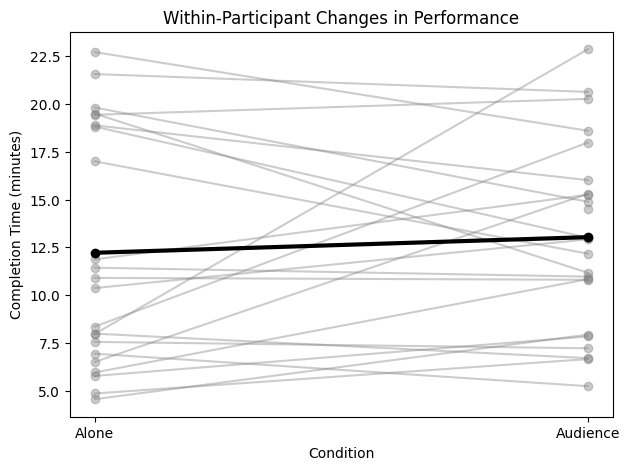

In [41]:
plt.figure(figsize=(7,5))

# Draw a thin line per participant
for pid, subdf in df.groupby('participant'):
    plt.plot(
        ['Alone', 'Audience'],
        subdf.sort_values('condition')['time_minutes'],
        marker='o',
        alpha=0.4,
        color='gray'
    )

# Add group means
means = df.groupby('condition')['time_minutes'].mean()
plt.plot(['Alone', 'Audience'], means, marker='o', color='black', linewidth=3)

plt.title("Within-Participant Changes in Performance")
plt.xlabel("Condition")
plt.ylabel("Completion Time (minutes)")
plt.show()


Interaction plot

c:\Users\maria\anaconda3\envs\MLenv2\Lib\site-packages\pingouin\plotting.py:573: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data["wthn"] = data[within].replace({_ordr: i for i, _ordr in enumerate(order)})


<Axes: xlabel='wthn', ylabel='time_minutes'>

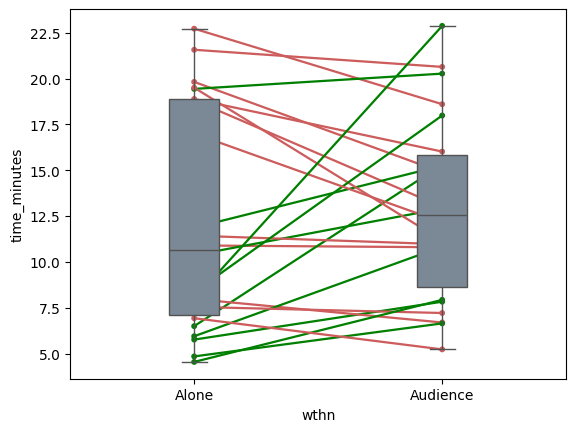

In [33]:
pg.plot_paired(
    data=df,
    dv='time_minutes',
    within='condition',
    subject='participant',
    boxplot=True
)

##### Nervousness & subjective reports

<Axes: xlabel='condition', ylabel='nervousness'>

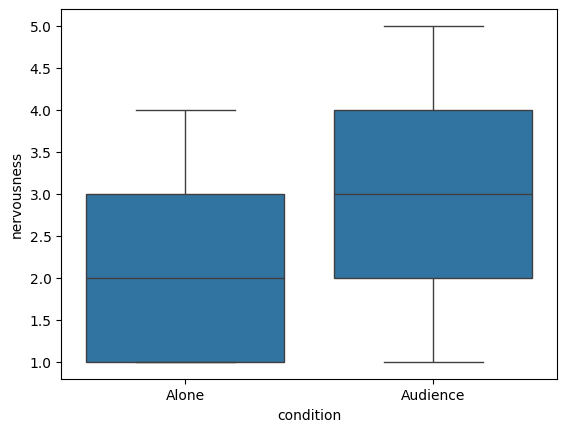

In [34]:
sns.boxplot(data=df, x='condition', y='nervousness')


,nervousness,time_minutes
nervousness,1.000000,0.427292
time_minutes,0.427292,1.000000


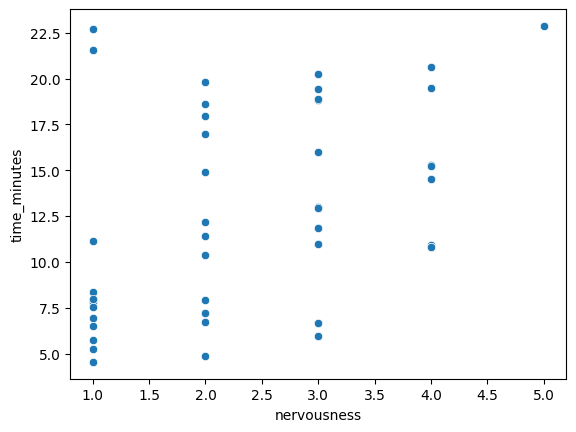

In [35]:
sns.scatterplot(data=df, x='nervousness', y='time_minutes')
df[['nervousness','time_minutes']].corr()

##### More stats / plots

In [44]:
df_diff = df.pivot_table(
    index='participant',
    columns='condition',
    values='time_minutes'
)

df_diff['difference'] = df_diff['Audience'] - df_diff['Alone']
df_diff.head()


condition,Alone,Audience,difference
participant,,,
1,5.766667,7.833333,2.066667
2,10.900000,10.800000,-0.100000
3,NaN,14.516667,NaN
4,6.500000,15.300000,8.800000
5,7.983333,6.700000,-1.283333


Histogram

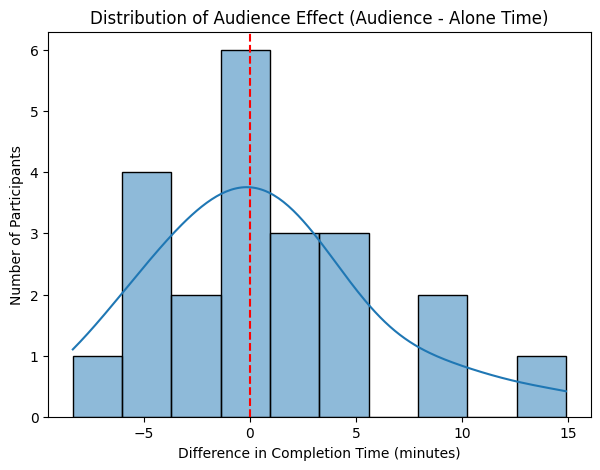

In [45]:
plt.figure(figsize=(7,5))
sns.histplot(df_diff['difference'], kde=True, bins=10)

plt.axvline(0, color='red', linestyle='--')
plt.title("Distribution of Audience Effect (Audience - Alone Time)")
plt.xlabel("Difference in Completion Time (minutes)")
plt.ylabel("Number of Participants")
plt.show()


Repeated-measures plot grouped by order group

C:\Users\maria\AppData\Local\Temp\ipykernel_17924\3130370519.py:2: FutureWarning: 

The `errwidth` parameter is deprecated. And will be removed in v0.15.0. Pass `err_kws={'linewidth': 1}` instead.

  sns.pointplot(


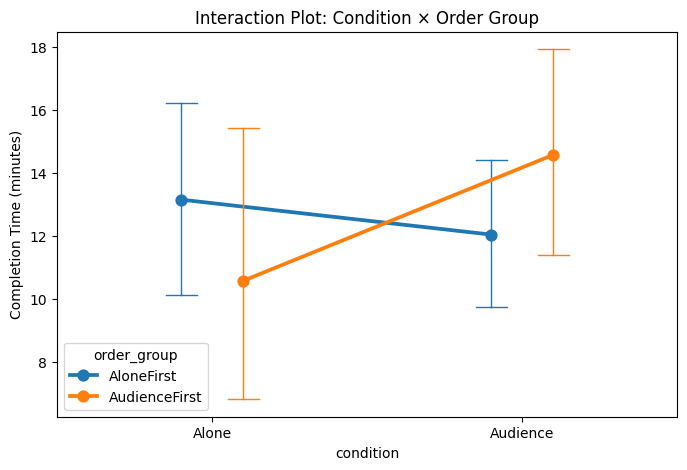

In [46]:
plt.figure(figsize=(8,5))
sns.pointplot(
    data=df,
    x='condition',
    y='time_minutes',
    hue='order_group',
    dodge=0.2,
    markers='o',
    capsize=.1,
    errwidth=1
)
plt.title("Interaction Plot: Condition × Order Group")
plt.ylabel("Completion Time (minutes)")
plt.show()
